In [100]:
import xarray as xr
import cmocean
import cartopy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd

In [10]:
ds = xr.open_dataset('../data/sst.day.mean.2021.2023.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 1095, lat: 89, lon: 359)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2023-12-31
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 81.0 83.0 85.0 87.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 354.0 355.0 356.0 357.0 358.0
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear

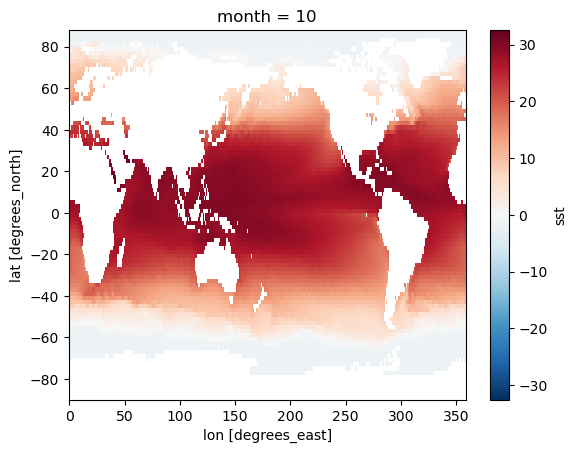

In [17]:
ds.groupby('time.month').mean().sel(month=10).sst.plot.pcolormesh()

Text(0.5, 1.0, 'October climatological SST')

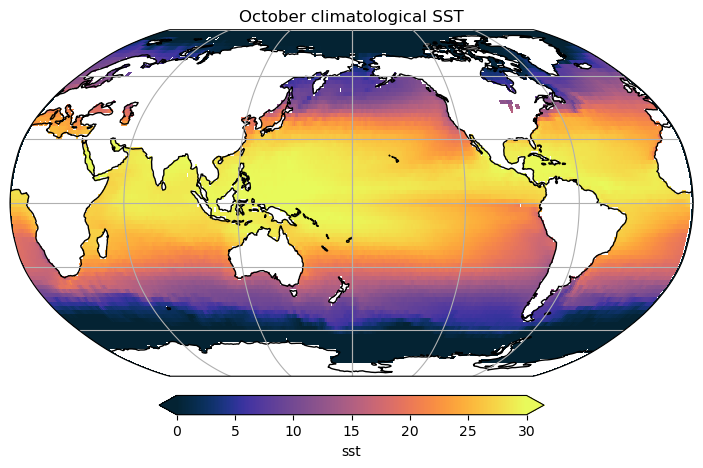

In [55]:
### Make it look a little nicer
cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05, pad=0.05)
kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), cbar_kwargs = cbar_kwargs)

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection':ccrs.Robinson(180)})
ds.groupby('time.month').mean().sel(month=10).sst.plot.pcolormesh(ax=ax, **kwargs, cmap=cmocean.cm.thermal, vmin=0, vmax=30)

ax.coastlines()
ax.gridlines()
ax.set_global()
ax.set_title('October climatological SST')

In [56]:
### Removing seasonal trend

plon, plat = 65, 15#-5+360, 65

Text(0, 0.5, 'Monthly mean SST at 65W, 15N ($\\degree$C)')

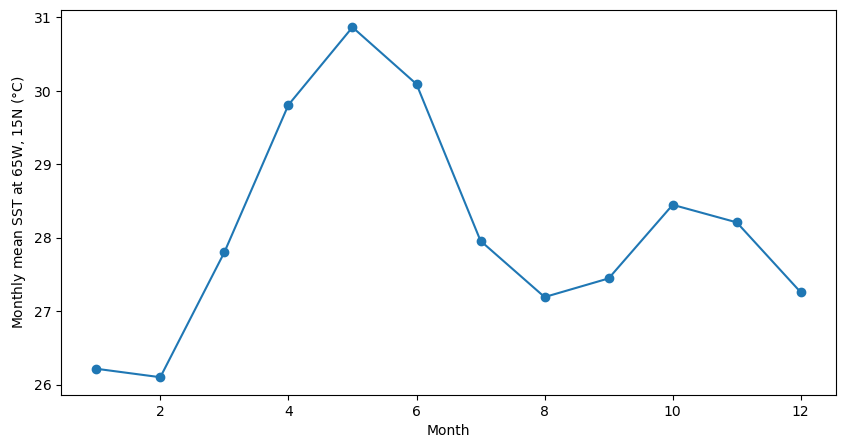

In [249]:
monthly_climatology = ds.sst.groupby('time.month').mean()

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, 13), monthly_climatology.sel(lat=plat, lon=plon))
plt.scatter(np.arange(1, 13), monthly_climatology.sel(lat=plat, lon=plon))
plt.xlabel('Month')
plt.ylabel(f'Monthly mean SST at {plon}W, {plat}N'+r' ($\degree$C)')

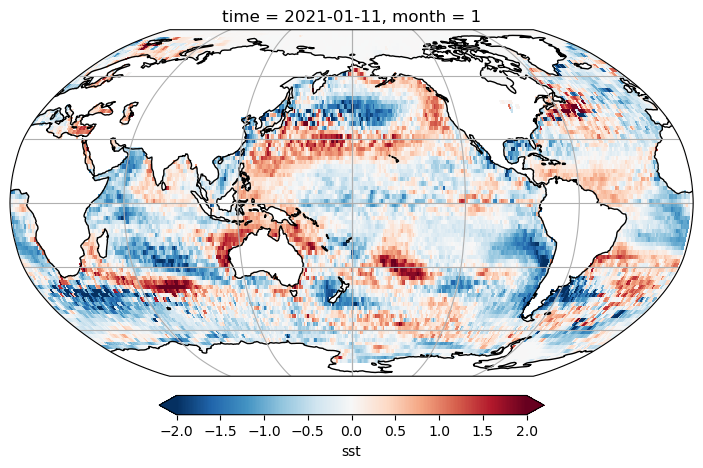

In [237]:
cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05, pad=0.05)
kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), cbar_kwargs = cbar_kwargs)

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection':ccrs.Robinson(180)})
#ds.groupby('time.month').mean().sel(month=10).sst.plot.pcolormesh(cmap=cmocean.cm.thermal, vmin=0, vmax=30)

ax.coastlines()
ax.gridlines()
ax.set_global()
ax.set_title('October climatological SST')

(ds.sst.groupby("time.month") - monthly_climatology).isel(time=10).plot.pcolormesh(ax=ax, **kwargs, vmin=-2, vmax=2, cmap='RdBu_r')

<Axes: >

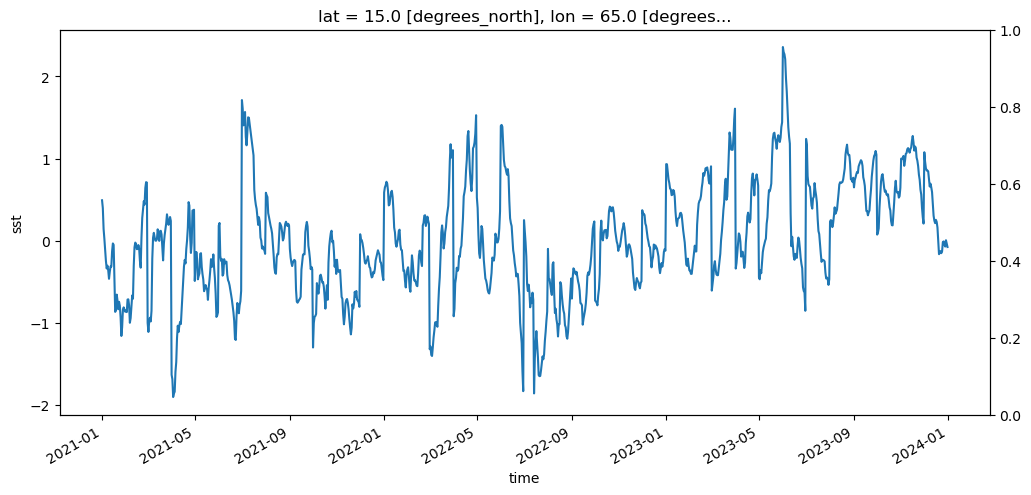

In [238]:
plt.figure(figsize=(12,5))
(ds.sst.groupby("time.month") - monthly_climatology).sel(lat=plat, lon=plon).plot()
plt.twinx()

In [239]:
date_range = xr.date_range("2021-01-01", "2024-01-01", freq="MS")

# access the month index (1, 2, ..., 12) for each date:
months = date_range.month

# create a DataArray from the above. The coordinate is the full date range
# and will become the time dim in the result. The values are the months
# that we would like to select from the climatology
selector = xr.DataArray(months, dims=["time"], coords=[date_range])

# select from the climatology, reshaping to be indexed by `time`
time_series = monthly_climatology.sel(month=selector)

In [240]:
monthly_anomaly = (ds.sst.groupby("time.month") - monthly_climatology)

Text(0, 0.5, 'Climatological SST ($\\degree$C)')

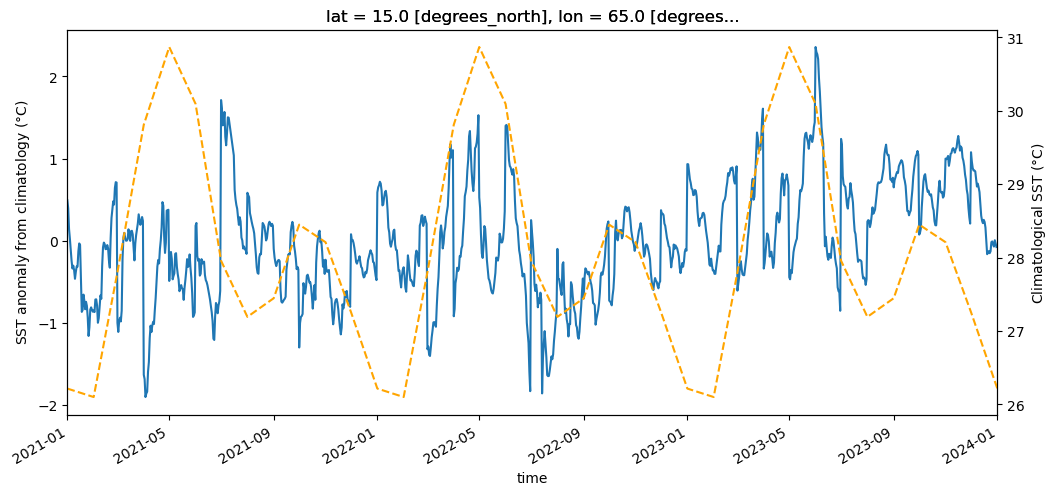

In [241]:
plt.figure(figsize=(12,5))
monthly_anomaly.sel(lat=plat, lon=plon).plot()
plt.ylabel('SST anomaly from climatology ($\degree$C)')
plt.twinx()
time_series.sel(lat=plat, lon=plon).plot(zorder=-1, color='orange',ls='--')
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2024-01-01'))
plt.ylabel('Climatological SST ($\degree$C)')


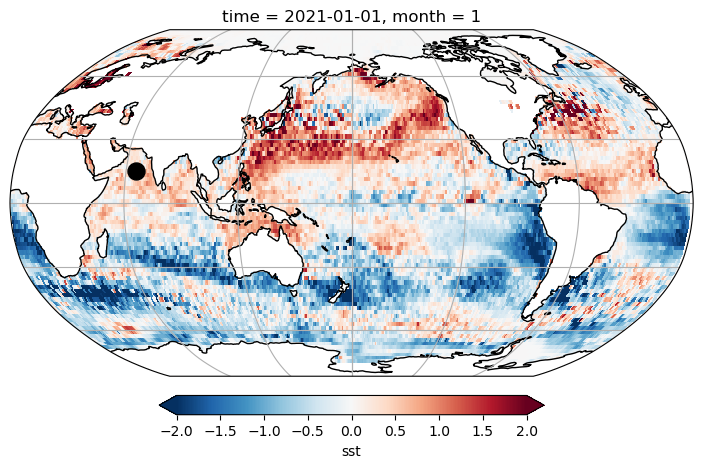

In [246]:
cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05, pad=0.05)
kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), cbar_kwargs = cbar_kwargs)

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection':ccrs.Robinson(180)})

ax.coastlines()
ax.gridlines()
ax.set_global()
ax.set_title('October climatological SST')

monthly_anomaly.isel(time=0).plot.pcolormesh(ax=ax, **kwargs, vmin=-2, vmax=2, cmap='RdBu_r')

plt.scatter(plon, plat, s=150, zorder=10, color='black', transform = ccrs.PlateCarree())


In [243]:
p = monthly_anomaly.polyfit(dim='time', deg=1)
fit = xr.polyval(monthly_anomaly['time'], p.polyfit_coefficients)

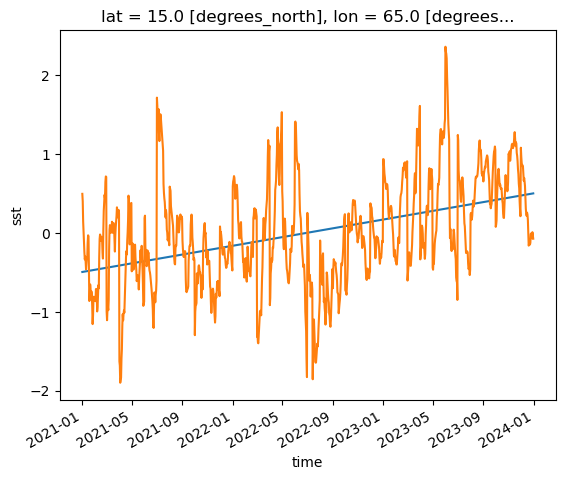

In [244]:
fit.sel(lon=plon, lat=plat).plot()
monthly_anomaly.sel(lon=plon, lat=plat).plot()

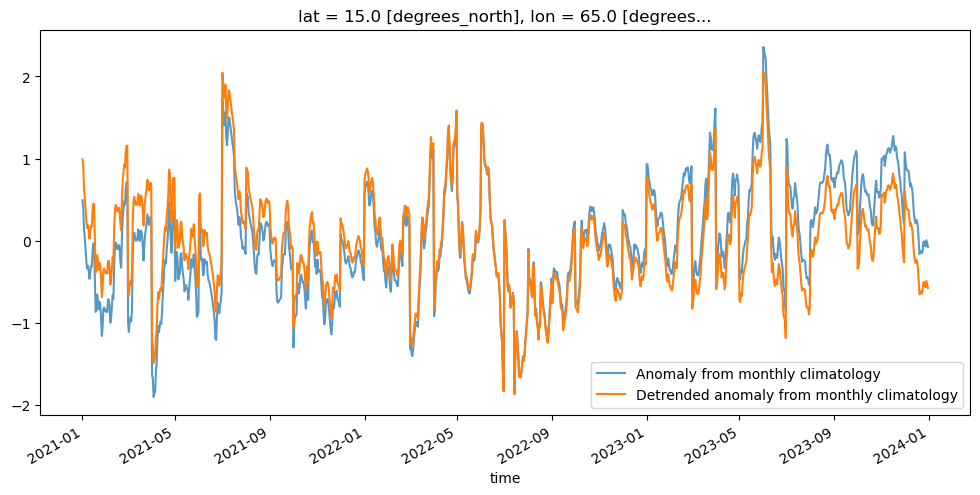

In [245]:
plt.figure(figsize=(12,5))
monthly_anomaly.sel(lon=plon, lat=plat).plot(alpha=0.75, label='Anomaly from monthly climatology')
(monthly_anomaly - fit).sel(lat=plat, lon=plon).plot( label='Detrended anomaly from monthly climatology')
plt.legend()